In [1]:
using GpABC, Distances, Distributions, Plots, StatsBase, Printf
using DiffEqCallbacks, DifferentialEquations, LinearAlgebra
using DelimitedFiles, DataFrames, LinearAlgebra, SparseArrays


In [2]:
include("/home/callum/ASF/Modules/ASF_input.jl");
include("/home/callum/ASF/Modules/ASF_model.jl");
include("/home/callum/ASF/Modules/ASF_analysis.jl")

Main.ASF_Analysis

In [3]:
function observed_params()
    
    obs =  Matrix{Float64}(undef,(3,1))
    
    endemic = 2 
    decline = 80
    peak = 180
    
    obs[1] = endemic
    obs[2] = decline
    obs[3] = peak
    
    return obs
end


observed_params (generic function with 1 method)

In [4]:
input_path = "/home/callum/ASF/ABC_INPUTS//";

In [5]:

input_1 = ASF_Inputs.Model_Data(input_path);

 Barabasi Albert Scale Free Network


In [6]:
nt = 1000#input_1.Parameters.Populations.cum_sum[end] #total number of groups and farms
nc = 5 #number of classes
eqs = 11 #number of processes
n_ens = 100 #number of runs in ensemble

dc = sparse(zeros(nt*nc,nt*eqs))

#const _dc = zeros(nt*5,nt*10)

dc[0*nc*nt+1:nc*nt*eqs+nc:end] .= 1
dc[1*nc*nt+1:nc*nt*eqs+nc:end] .= -1
dc[2*nc*nt+1:nc*nt*eqs+nc:end] .= -1
dc[10*nc*nt+1:nc*nt*eqs+nc:end] .= 1

dc[2*nc*nt+2:nc*nt*eqs+nc:end] .= 1
dc[3*nc*nt+2:nc*nt*eqs+nc:end] .= -1
dc[4*nc*nt+2:nc*nt*eqs+nc:end] .= -1

dc[4*nc*nt+3:nc*nt*eqs+nc:end] .= 1
dc[5*nc*nt+3:nc*nt*eqs+nc:end] .= -1
dc[6*nc*nt+3:nc*nt*eqs+nc:end] .= -1
dc[7*nc*nt+3:nc*nt*eqs+nc:end] .= -1

dc[7*nc*nt+4:nc*nt*eqs+nc:end] .= 1
dc[8*nc*nt+4:nc*nt*eqs+nc:end] .= -1
dc[10*nc*nt+4:nc*nt*eqs+nc:end] .= -1


dc[5*nc*nt+5:nc*nt*eqs+nc:end] .= 1
dc[6*nc*nt+5:nc*nt*eqs+nc:end] .= 1
dc[9*nc*nt+5:nc*nt*eqs+nc:end] .= -1;

In [7]:
function regular_c(du,u,p,t,counts,mark)  
    mul!(du,dc,counts)
    nothing
end

regular_c (generic function with 1 method)

In [8]:
function convert(input)
    
    params = Vector{Any}(undef,13)
    
    params[1]  = input.β
    params[2]  = input.β_b
    params[3]  = input.β_d
    
    params[4]  = input.μ_b
    params[5]  = input.μ_d
    params[6]  = input.μ_c
    
    params[7]  = input.ζ
    params[8]  = input.γ
    params[9]  = input.ω
    params[10] = input.ρ
    params[11] = input.λ
    params[12] = input.κ
    
    params[13] = input.Populations
    
    return params
    
end

convert (generic function with 1 method)

In [10]:
function asf_model(out,u,p,t)
    
    #ref_density = 1
    u[u.<0].=0 
    
    β, β_b, β_d, μ_b, μ_d, μ_c, ζ, γ, ω, ρ, λ, κ, Pops= p
    
    S = Vector{UInt8}(u[1:5:end])
    E = Vector{UInt8}(u[2:5:end])
    I = Vector{UInt8}(u[3:5:end])
    R = Vector{UInt8}(u[4:5:end])
    C = Vector{UInt8}(u[5:5:end])
    
    tp = Pops.cum_sum[end]
    N = S + E + I + R + C
    Np = S + E + I + R
    
    N[N .== 0] .= 1
    v = ones(Int8,tp)

    populations  = v*N'+ N*v'
    populations[diagind(populations)] = N;

    beta = copy(β)
    N_feral = sum(Np)
    Density = N_feral/Pops.area[1]
    beta[β_d .== 1] .*= Density
    
    
    if seasons ==  true
        b_test = copy(μ_b)
        d_test = copy(μ_d)
        λ_test = copy(λ)
        day = mod(t, 365)
        #will have 3 seasons
        if day < 121
            ratiob = 5/3
            ratiod = 1
            
            b_test .*= ratiob
            d_test .*= ratiob
            λ_test .*= 1/ratiod
            beta[β_d .== 1] .*= 1/2
            
        elseif 121 <= day <= 243
            ratiob = 1
            ratiod = 1
            
            b_test .*= ratiob
            d_test .*= ratiob
            λ_test .*= 1/ratiod
        else
            ratiob = 1/3
            ratiod = 1
            
            b_test .*= ratiob
            d_test .*= ratiob
            λ_test .*= 1/ratiod
            beta[β_d .== 1] .*= 3/2
        end
    else 
        b_test = μ_b
        d_test = μ_b
        λ_test = λ
    end
        
    
    connected_pops = β_b * Np
    
    g_eff  = (b_test-d_test)./tanh(1).*tanh.(Np./μ_c) 
 
    Births = b_test .* Np
    Births[(μ_c .== 1) .& (Np .> 0)] .= 0 #preventing boar populations growing larger than one!
    Births[(Np .== 0) .& (connected_pops .>2)] .= mean(μ_b)*2 #allowing migration births if neighbouring groups have pop
    Infect = ((beta .* S) ./ populations) * (I + ω .* C)#ASF Infections
    Infectous = ζ .* E
    Recover = γ .* (1 .- ρ) .* I #ASF Recoveries
    Death_I = ρ .* γ .* I #ASF Deaths in I
    Death_nI = d_test .* I+ g_eff.*I #Natural Deaths in I
    Death_S = d_test .* S + g_eff.*S #Natural Deaths S
    Death_E = d_test .* E + g_eff.*E
    Death_R = d_test .* R + g_eff.*R #Natural Deaths R
    Decay_C = λ_test .* C #Body Decomposition 
    W_Immunity = κ .* R 
    
    out[1:11:end] = Births
    out[2:11:end] = Death_S
    out[3:11:end] = Infect
    out[4:11:end] = Death_E
    out[5:11:end] = Infectous
    out[6:11:end] = Death_I
    out[7:11:end] = Death_nI
    out[8:11:end] = Recover
    out[9:11:end] = Death_R
    out[10:11:end] = Decay_C  
    out[11:11:end] = W_Immunity  
    

    nothing
end

asf_model (generic function with 1 method)

In [11]:
function decay_days(mean,multi)
    rate = (1/mean)*1/multi
    println(1/rate)
    nothing
end
    

decay_days (generic function with 1 method)

In [12]:
function SEIRC_ODE!(du,u,p,t)
    
     u[u.<0].=0 
    
    β, β_b, β_d, μ_b, μ_d, μ_c, ζ, γ, ω, ρ, λ, κ, Pops= p
    
     S = u[1:5:end]
    E = u[2:5:end]
    I = u[3:5:end]
    R = u[4:5:end]
    C = u[5:5:end]
    
    tp = Pops.cum_sum[end]
    N = S + E + I + R + C
    Np = S + E + I + R
    
    N[N .== 0] .= 1
    v = ones(Int8,tp)

    populations  = v*N'+ N*v'
    populations[diagind(populations)] = N;

    beta = deepcopy(β)
    N_feral = sum(Np)
    Dens = N_feral/Pops.area[1]
    D_t = Float32.(Dens)
        
   
    beta[β_d .== 1] .*= D_t

    connected_pops = β_b * Np

    #procceses 
    Births = μ_b .* Np
    Births[(μ_c .== 1) .& (Np .> 0)] .= 0 #preventing boar populations growing larger than one!
    Births[(Np .== 0) .& (connected_pops .>2)] .= mean(μ_b)*2 #allowing migration births if neighbouring groups have pop
    

    
    du[1:5:end] = Births - ((beta.* S) ./ populations) * (I + ω .* C) - μ_d .* S + (μ_b-μ_d)./tanh(1).*S.*tanh.(Np./μ_c)  + κ .* R #S
    du[2:5:end] = ((beta.* S) ./ populations) * (I + ω .* C) - ζ .* E - μ_d .* E + (μ_b-μ_d)./tanh(1).*E.*tanh.(Np./μ_c) #E
    du[3:5:end] = ζ .* E - γ .* I -  μ_d .* I+ (μ_b-μ_d)./tanh(1).*I.*tanh.(Np./μ_c) #I
    du[4:5:end] = γ .* (1 .- ρ) .* I - μ_d .* R + (μ_b-μ_d)./tanh(1).*R.*tanh.(Np./μ_c) - κ .* R  #R
    du[5:5:end] = ρ .* γ .* I + μ_d .* I+ (μ_b-μ_d)./tanh(1).*I.*tanh.(Np./μ_c) - λ .* C#C
    nothing
end

SEIRC_ODE! (generic function with 1 method)

In [13]:
AUSASF = function(params,Tspan, U0)
    
    rj = RegularJump(asf_model, regular_c, eqs*nt)
    prob = DiscreteProblem(U0,Tspan,params)
    jump_prob = JumpProblem(prob,Direct(),rj)
    #sol = solve(jump_prob, SimpleTauLeaping(), dt= 1)
    ensemble_prob_m = EnsembleProblem(jump_prob)
    outputs = solve(ensemble_prob_m, SimpleTauLeaping(), trajectories= n_runs,EnsembleThreads(),dt=1);
    res = eval_out(outputs)
    
    return res
end
    

#1 (generic function with 1 method)

In [14]:
AUSASF_ode = function(params,Tspan, U0)
    
    prob = ODEProblem(SEIRC_ODE!,U0,Tspan,params);
    outputs = solve(prob, AutoTsit5(Rosenbrock23()),saveat=1)

    #outputs = solve(ensemble_prob_m, SimpleTauLeaping(), trajectories= n_runs,EnsembleThreads(),dt=1);
    res = eval_out(outputs)
    
    return res
end
    

#3 (generic function with 1 method)

In [15]:
function simulator_function_ode(var_params)
    params = deepcopy(true_params)
    
    #beta
    params[1][diagind(params[1])] .= var_params[1] #intra
    params[1][params[2] .== 1 ] .= var_params[2] #inter
    
    params[10] .= var_params[3]
    
    #corpse 
    params[9] .= var_params[4] #corpse infection modifier
    params[11] .= var_params[5] #corpse decay rates
    
    #now we run simulation!
    AUSASF_ode(params, Tspan, U0)
end

simulator_function_ode (generic function with 1 method)

In [16]:
function simulator_function(var_params)
    params = deepcopy(true_params)
    
    #beta
    params[1][diagind(params[1])] .= var_params[1] #intra
    params[1][params[2] .== 1 ] .= var_params[2] #inter
    
    params[10] .= var_params[3]
    
    #corpse 
    params[9] .= var_params[4] #corpse infection modifier
    params[11] .= var_params[5] #corpse decay rates
    
    #now we run simulation!
    AUSASF(params, Tspan, U0)
end

simulator_function (generic function with 1 method)

In [17]:
function eval_out(output)
    
    output_final = Matrix{Float64}(undef,(3,1))
    
    prev_data = Vector{Float64}(undef,n_runs)
    die_data  = Vector{Float64}(undef,n_runs)
    time_data = Vector{Float64}(undef,n_runs)
    
    for i = 1:n_runs
        sol = output[i]
        data = reduce(vcat,transpose.(sol.u))
        data[data .< 0 ] .= 0

        s_d = data[:,1:5:end]
        e_d = data[:,2:5:end]
        i_d = data[:,3:5:end]
        r_d = data[:,4:5:end]
        c_d = data[:,5:5:end]

        disease_total = e_d + i_d + c_d #classes with disease
        disease_alive = e_d + i_d

        disease_free = s_d + r_d #classes without disease

        disease_sum = sum(disease_total,dims=2)
        disease_alive_sum =  sum(disease_alive,dims=2)
        disease_free_sum = sum(disease_free,dims=2)
        population_sum = disease_alive_sum + disease_free_sum

        end_prev = 100*(disease_alive_sum[end]/disease_free_sum[end])
        pop_decline = 100*(1-population_sum[end]/U0_sum)
        max_time = findfirst(==(maximum(disease_sum)), disease_sum)[1]

        prev_data[i] = end_prev/obs[1]
        die_data[i] = pop_decline/obs[2]
        time_data[i] = max_time/obs[3]
    
    end
    
    output_final[1] = mean(prev_data)
    output_final[2] = mean(die_data)
    output_final[3] = mean(time_data)
    #println(res)
    
    d = norm(output_final-obs_test) 
    if d < 1
    println(d)
    println(output_final)
    end
    
    #if output_final[1] > 0
     #   println(output_final[1])
    #end
    
    #println(output_final)
    return output_final
    
end

eval_out (generic function with 1 method)

In [18]:
input_1 = ASF_Inputs.Model_Data(input_path);

 Barabasi Albert Scale Free Network


In [19]:
obs = observed_params()
obs_test= observed_params()*0 .+ 1

3×1 Matrix{Float64}:
 1.0
 1.0
 1.0

In [20]:
input_1 = ASF_Inputs.Model_Data("/home/callum/ASF/Inputs/");
true_params = convert(input_1.Parameters);
Tspan = (0.0,5*365.0)
U0 = input_1.U0;
U0_sum = sum(U0);
n_runs = 1;

 Barabasi Albert Scale Free Network


In [ ]:
priors = [Uniform(0.1, 1.), Uniform(0.01, 0.1), Uniform(0.8, 1.), Uniform(0.1, 1.), Uniform(0.01, 0.1)]

In [ ]:
n_particles = 100
threshold = 1.0
sim_result = SimulatedABCRejection(obs_test, simulator_function, priors, threshold, n_particles; max_iter=100, write_progress=false)#,

In [ ]:
sim_result.population

# sim_result.population

In [21]:
seasons = true

true

In [22]:
input_1 = ASF_Inputs.Model_Data("/home/callum/ASF/Inputs/");
true_params = convert(input_1.Parameters);
Tspan = (0.0,10*365.0)
U0 = input_1.U0;
U0_sum = sum(U0);
n_runs = 1;

 Barabasi Albert Scale Free Network


In [23]:
rj = RegularJump(asf_model, regular_c, eqs*nt)
prob = DiscreteProblem(U0,Tspan,true_params)
jump_prob = JumpProblem(prob,Direct(),rj)
sol = solve(jump_prob, SimpleTauLeaping(), dt= 1);

In [24]:
ensemble_prob_m = EnsembleProblem(jump_prob)
output = solve(ensemble_prob_m, SimpleTauLeaping(), trajectories= 10,EnsembleThreads(),dt=1);


In [25]:
end_sum = mid_sum = 0
for i = 1:10
    sol = output[i]
    data = reduce(vcat,transpose.(sol.u))
    data[data .< 0 ] .= 0

    s_d = data[:,1:5:end]
    e_d = data[:,2:5:end]
    i_d = data[:,3:5:end]
    r_d = data[:,4:5:end]
    c_d = data[:,5:5:end]

    disease_total = e_d + i_d + c_d #classes with disease
    disease_alive = e_d + i_d

    disease_free = s_d + r_d #classes without disease

    disease_sum = sum(disease_total,dims=2)
    disease_alive_sum =  sum(disease_alive,dims=2)
    disease_free_sum = sum(disease_free,dims=2)
    population_sum = disease_alive_sum + disease_free_sum

    if disease_sum[end] >0
        end_sum += 1
    end
    if disease_sum[5*365] >0
        mid_sum += 1
    end

end

println(end_sum)
println(mid_sum)
    

5
6


3651
1352
1258
3651
3651
Need to Reduce Timestep
3651
2969
1500
3651
1623

2695.7


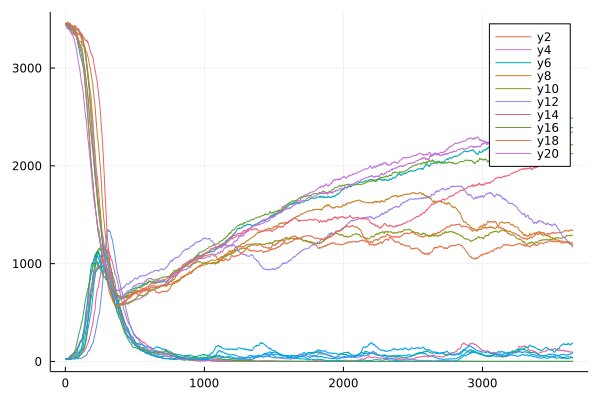

In [26]:
plot()
store = Vector{Int32}(undef,10)
for i in 1:10
    sol = output[i]
    data = reduce(vcat,transpose.(sol.u))

    if any(x->x <0, data)
        println("Need to Reduce Timestep")
        data[data .< 0 ] .= 0
    end

    s_d = data[:,1:5:end]
    e_d = data[:,2:5:end]
    i_d = data[:,3:5:end]
    r_d = data[:,4:5:end]
    c_d = data[:,5:5:end]
    
    disease_total = e_d + i_d + c_d #classes with disease
    disease_alive = e_d + i_d

    disease_free = s_d + r_d #classes without disease

    disease_sum = sum(disease_total,dims=2)
    diease_alive_sum =  sum(disease_alive,dims=2)
    disease_free_sum = sum(disease_free,dims=2)
    population_sum = diease_alive_sum + disease_free_sum;
    
    prev_times = maximum(findall(!=(0), disease_sum))[1]
    println(prev_times)
    #if disease_sum[end] == 0
     #   println("DIED OUT")
    #end
    
    plot!(disease_sum, label = "")
    #plot!(disease_free_sum, label = "")
    plot!(sum(s_d,dims=2))
    store[i] = prev_times
end
println()
println(mean(store))
plot!()

3651
1352
1258
3651
3651
Need to Reduce Timestep
3651
2969
1500
3651
1623

2695.7


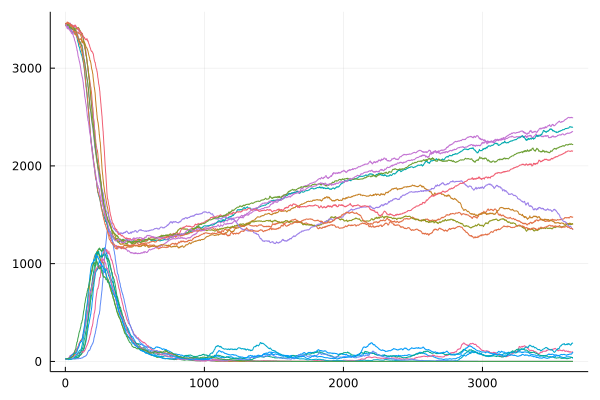

In [27]:
plot()
store = Vector{Int32}(undef,10)
for i in 1:10
    sol = output[i]
    data = reduce(vcat,transpose.(sol.u))

    if any(x->x <0, data)
        println("Need to Reduce Timestep")
        data[data .< 0 ] .= 0
    end

    s_d = data[:,1:5:end]
    e_d = data[:,2:5:end]
    i_d = data[:,3:5:end]
    r_d = data[:,4:5:end]
    c_d = data[:,5:5:end]

    disease_total = e_d + i_d + c_d #classes with disease
    disease_alive = e_d + i_d

    disease_free = s_d + r_d #classes without disease

    disease_sum = sum(disease_total,dims=2)
    diease_alive_sum =  sum(disease_alive,dims=2)
    disease_free_sum = sum(disease_free,dims=2)
    population_sum = diease_alive_sum + disease_free_sum;
    
    prev_times = maximum(findall(!=(0), disease_sum))[1]
    println(prev_times)
    #if disease_sum[end] == 0
     #   println("DIED OUT")
    #end
    
    plot!(disease_sum, label = "")
    plot!(disease_free_sum, label = "")
    store[i] = prev_times
end
println()
println(mean(store))
plot!()

In [ ]:
i=1
sol = output[i]
    data = reduce(vcat,transpose.(sol.u))

    if any(x->x <0, data)
        println("Need to Reduce Timestep")
        data[data .< 0 ] .= 0
    end

    s_d = data[:,1:5:end]
    e_d = data[:,2:5:end]
    i_d = data[:,3:5:end]
    r_d = data[:,4:5:end]
    c_d = data[:,5:5:end]

    disease_total = e_d + i_d + c_d #classes with disease
    disease_alive = e_d + i_d

    disease_free = s_d + r_d #classes without disease

    disease_sum = sum(disease_total,dims=2)
    diease_alive_sum =  sum(disease_alive,dims=2)
    disease_free_sum = sum(disease_free,dims=2)
    population_sum = diease_alive_sum + disease_free_sum;

In [ ]:
maximum(findall(!=(0), disease_sum))[1]

In [ ]:
plot(disease_sum, label = "")
plot!(disease_free_sum)

In [ ]:
diease_alive_sum

In [ ]:
plot(sol)

In [ ]:
median(sim_result.population[:,1])

In [ ]:
median(sim_result.population[:,2])

In [ ]:
median(sim_result.population[:,3])

In [ ]:
median(sim_result.population[:,4])

In [ ]:
plot(sim_result)

In [ ]:
median(sim_result.population[:,4])

In [ ]:
1/0.015021101514961837

In [ ]:


#
# ABC-SMC settings
#
threshold_schedule = [3.0, 2.0, 1.0, 0.5, 0.2];



In [ ]:


population_colors=["#FF2F4E", "#D0001F", "#A20018", "#990017", "#800013"]
sim_abcsmc_res = SimulatedABCSMC(obs_test,
    simulator_function,
    priors,
    threshold_schedule,
    n_particles; max_iter = 10000,
    write_progress=true)
#plot(sim_abcsmc_res, population_colors=population_colors)



In [ ]:
plot(sim_abcsmc_res, population_colors=population_colors)

In [ ]:
n_design_points = 500
emu_result = EmulatedABCRejection(obs_test, simulator_function, priors, threshold, n_particles, n_design_points; max_iter=1000,write_progress=false)
plot(emu_result)


In [ ]:
n_particles